## Forecasting Interest Rates using Machine Learning Techniques
### Steve Hall
### December 2019

In [27]:
# import libraries
import pandas as pd 
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load database of market prices into pandas
raw = pd.read_csv('./data/db_MarketPredictors.csv', sep=',')

In [3]:
print(raw.shape)
raw.head()

(7807, 197)


,Day,Date,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,...,NG6 Comdty,XB6 Comdty,GC6 Comdty,SI6 Comdty,KC6 Comdty,SB6 Comdty,C 6 Comdty,W 6 Comdty,CT6 Comdty,LH6 Comdty
0,3,12/3/2019,3113.87,981.57,1995.86,8309.260,176.69,953.4808,635.73,431.49,...,2.246,173.95,1488.8,17.460,129.80,13.60,391.50,556.00,67.82,84.775
1,2,12/2/2019,3113.87,981.57,1995.86,8309.260,176.69,953.4808,635.73,431.49,...,2.217,175.20,1488.8,17.368,129.65,13.58,391.25,554.25,67.96,84.775
2,6,11/29/2019,3140.98,993.51,2010.15,8403.685,178.24,960.7933,634.09,431.37,...,2.193,175.44,1492.5,17.487,126.70,13.62,391.00,556.50,67.39,86.150
3,5,11/28/2019,3153.63,999.99,2030.78,8444.709,178.89,968.2137,635.00,435.78,...,2.312,182.76,1480.3,17.426,126.45,13.54,389.00,548.00,68.19,86.050
4,4,11/27/2019,3153.63,999.99,2030.78,8444.709,178.89,968.2137,635.00,435.78,...,2.312,182.76,1480.3,17.426,126.45,13.54,389.00,548.00,68.19,86.050


I have downloaded 195 series of market price data. The futures data is adjusted for the roll, applying the difference between the prompt and next contract 5 days prior to expiration.
<br>
<br>
*Data source: Bloomberg; daily from 1/1/1990 through 12/3/2019.* 

In [4]:
raw['Date'] =pd.to_datetime(raw.Date)
raw = raw.sort_values('Date')

In [5]:
# let's add year and month-year to the dataframe
raw['Year'] = pd.DatetimeIndex(raw['Date']).year
raw['Year_MM'] = pd.to_datetime(raw['Date']).dt.to_period('M')
dates = raw['Date']
raw.head()

,Day,Date,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,...,GC6 Comdty,SI6 Comdty,KC6 Comdty,SB6 Comdty,C 6 Comdty,W 6 Comdty,CT6 Comdty,LH6 Comdty,Year,Year_MM
7806,2,1990-01-01,353.40,NaN,NaN,223.835,99.89,71.2032,62.33,91.62,...,896.3,12.258,294.10,9.15,457.9375,1087.375,81.58,-22.675,1990,1990-01
7805,3,1990-01-02,359.69,NaN,NaN,227.725,101.27,73.3261,62.86,92.03,...,892.6,12.238,293.35,9.10,455.4375,1086.875,81.08,-22.875,1990,1990-01
7804,4,1990-01-03,358.76,NaN,NaN,226.100,100.47,73.1502,62.72,90.74,...,887.0,12.209,294.60,9.60,457.4375,1086.875,81.83,-22.675,1990,1990-01
7803,5,1990-01-04,355.67,NaN,NaN,224.715,97.78,72.8757,61.89,89.68,...,891.9,12.334,295.10,9.81,458.9375,1086.875,80.78,-21.100,1990,1990-01
7802,6,1990-01-05,352.20,NaN,NaN,223.140,95.64,72.3403,61.38,88.79,...,899.6,12.384,293.88,9.91,458.1875,1087.875,80.70,-20.125,1990,1990-01


In [6]:
# remove day and date from the dataframe
raw_prices = raw.iloc[:,2:-2]
raw_prices.head()

,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,NG6 Comdty,XB6 Comdty,GC6 Comdty,SI6 Comdty,KC6 Comdty,SB6 Comdty,C 6 Comdty,W 6 Comdty,CT6 Comdty,LH6 Comdty
7806,353.40,NaN,NaN,223.835,99.89,71.2032,62.33,91.62,76.14,72.56,...,NaN,NaN,896.3,12.258,294.10,9.15,457.9375,1087.375,81.58,-22.675
7805,359.69,NaN,NaN,227.725,101.27,73.3261,62.86,92.03,77.35,73.63,...,NaN,NaN,892.6,12.238,293.35,9.10,455.4375,1086.875,81.08,-22.875
7804,358.76,NaN,NaN,226.100,100.47,73.1502,62.72,90.74,77.48,74.18,...,NaN,NaN,887.0,12.209,294.60,9.60,457.4375,1086.875,81.83,-22.675
7803,355.67,NaN,NaN,224.715,97.78,72.8757,61.89,89.68,76.97,73.68,...,NaN,NaN,891.9,12.334,295.10,9.81,458.9375,1086.875,80.78,-21.100
7802,352.20,NaN,NaN,223.140,95.64,72.3403,61.38,88.79,76.24,72.60,...,NaN,NaN,899.6,12.384,293.88,9.91,458.1875,1087.875,80.70,-20.125


In [7]:
# create a df of statistics of the market prices
stats_prices = raw_prices.describe().transpose()

In [8]:
# now let's calculate daily price returns for each series
raw_rets = raw_prices.pct_change()
# add back the unique months-years
raw_rets['Year_MM'] = raw['Year_MM'] 
raw_rets.head()

,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,XB6 Comdty,GC6 Comdty,SI6 Comdty,KC6 Comdty,SB6 Comdty,C 6 Comdty,W 6 Comdty,CT6 Comdty,LH6 Comdty,Year_MM
7806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-01
7805,0.017799,NaN,NaN,0.017379,0.013815,0.029815,0.008503,0.004475,0.015892,0.014746,...,NaN,-0.004128,-0.001632,-0.002550,-0.005464,-0.005459,-0.00046,-0.006129,0.008820,1990-01
7804,-0.002586,NaN,NaN,-0.007136,-0.007900,-0.002399,-0.002227,-0.014017,0.001681,0.007470,...,NaN,-0.006274,-0.002370,0.004261,0.054945,0.004391,0.00000,0.009250,-0.008743,1990-01
7803,-0.008613,NaN,NaN,-0.006126,-0.026774,-0.003753,-0.013233,-0.011682,-0.006582,-0.006740,...,NaN,0.005524,0.010238,0.001697,0.021875,0.003279,0.00000,-0.012831,-0.069460,1990-01
7802,-0.009756,NaN,NaN,-0.007009,-0.021886,-0.007347,-0.008240,-0.009924,-0.009484,-0.014658,...,NaN,0.008633,0.004054,-0.004134,0.010194,-0.001634,0.00092,-0.000990,-0.046209,1990-01


In [9]:
# create a df of statistics of the market prices
stats_rets = raw_rets.describe().transpose()

In [10]:
# average monthly returns
monthly_rets = raw_rets.groupby(['Year_MM']).sum()
monthly_rets.head()

,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,NG6 Comdty,XB6 Comdty,GC6 Comdty,SI6 Comdty,KC6 Comdty,SB6 Comdty,C 6 Comdty,W 6 Comdty,CT6 Comdty,LH6 Comdty
Year_MM,,,,,,,,,,,,,,,,,,,,,
1990-01,-0.069845,0.0,0.0,-0.100755,-0.135176,-0.067095,-0.099511,-0.036108,-0.110280,-0.066651,...,0.000000,0.0,0.011318,-0.000954,-0.009802,0.109309,-0.008090,-0.008758,0.015696,-0.127050
1990-02,0.009007,0.0,0.0,0.029817,-0.004466,0.018933,-0.015465,0.018433,0.032155,-0.027902,...,0.000000,0.0,-0.010069,-0.009129,0.040157,-0.023497,0.019195,-0.000448,-0.008390,-0.019234
1990-03,0.024480,0.0,0.0,0.025821,0.049772,0.029731,0.056362,0.003447,-0.031671,0.033875,...,0.000000,0.0,-0.047333,-0.019215,-0.004865,0.089666,0.003372,-0.016800,0.006884,-0.078533
1990-04,-0.026771,0.0,0.0,-0.034203,-0.036512,-0.037562,0.012241,-0.038407,-0.044783,0.003263,...,-0.003993,0.0,-0.002698,-0.002137,-0.001632,0.044573,0.035624,-0.001363,0.019265,-0.225010
1990-05,0.088675,0.0,0.0,0.138619,0.083135,0.102705,0.098296,0.060451,0.115542,0.121566,...,0.004011,0.0,-0.010081,0.006470,0.005874,-0.174647,-0.004787,0.005805,0.028105,0.032635


In [11]:
# number of months
len(monthly_rets)

360

In [12]:
# instead of summing daily returns we could calculate rolling 21 day returns (roughly 21 days/ month)
# let's create a function
def rolling_pct_rets(df, periods):
    rets = (df.shift(periods=periods, fill_value=0)/ df) - 1
    rets = rets[:periods]
    return rets

In [13]:
lookback = 21
monthly_rets2 = rolling_pct_rets(raw_prices, -lookback)
# append dates to this for later
monthly_rets2.shape

(7786, 195)

In [14]:
# append dates to monthly_rets
Day = raw['Date'][:-21]
monthly_rets2 = pd.concat((monthly_rets2, Day), axis=1)
#monthly_rets2 = monthly_rets2.sort_values('Date')

In [15]:
monthly_rets2.tail(22)

,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,XB6 Comdty,GC6 Comdty,SI6 Comdty,KC6 Comdty,SB6 Comdty,C 6 Comdty,W 6 Comdty,CT6 Comdty,LH6 Comdty,Date
42,0.042771,0.062711,0.047962,0.058880,0.041742,0.021376,-0.013462,0.064565,0.068888,0.048081,...,0.074141,-0.000195,0.029127,0.036673,-0.012310,-0.001237,0.028869,0.045427,-0.007349,2019-10-04
41,0.046220,0.066189,0.055585,0.062788,0.040587,0.027348,-0.003104,0.079336,0.078188,0.043187,...,0.080304,-0.012359,0.005953,0.073569,0.008065,-0.010455,0.035495,0.042221,0.025021,2019-10-07
40,0.063504,0.078782,0.069586,0.077819,0.052351,0.039752,0.011516,0.073769,0.104979,0.068582,...,0.057982,-0.006083,-0.000938,0.105287,0.001472,-0.019560,0.019079,0.052209,0.005214,2019-10-08
39,0.056786,0.077879,0.063428,0.068801,0.055418,0.024722,0.000064,0.079204,0.101381,0.062827,...,0.063336,-0.029129,-0.039193,0.116483,0.005201,-0.022630,0.014439,0.052575,0.005438,2019-10-09
38,0.052738,0.076441,0.060621,0.066602,0.052543,0.019564,-0.001792,0.056905,0.090386,0.065839,...,0.047647,-0.024176,-0.038982,0.138642,0.010409,-0.009877,0.025472,0.069120,0.010366,2019-10-10
37,0.039303,0.053463,0.040640,0.050745,0.037620,0.005261,-0.002770,0.036469,0.073785,0.052994,...,0.023936,-0.020147,-0.037315,0.106075,0.008895,-0.028659,-0.003235,0.049424,0.007590,2019-10-11
36,0.042375,0.057178,0.042933,0.053741,0.042818,0.005099,0.003828,0.031599,0.072892,0.059464,...,0.038168,-0.028365,-0.052675,0.090320,0.010378,-0.023199,0.011055,0.051952,0.006213,2019-10-14
35,0.032834,0.039583,0.032297,0.039905,0.030532,-0.008281,0.016502,0.022296,0.052728,0.042269,...,0.050769,-0.012856,-0.022894,0.118937,0.007342,-0.027523,0.002316,0.037583,0.001880,2019-10-15
34,0.035770,0.034739,0.035924,0.042628,0.032126,-0.008856,0.014294,0.034744,0.056256,0.042736,...,0.034431,-0.012900,-0.019143,0.132235,0.020833,-0.023256,-0.008744,0.027108,-0.013126,2019-10-16
33,0.040865,0.028574,0.031960,0.047012,0.032853,-0.010561,0.011233,0.041280,0.059845,0.057773,...,0.045375,-0.018966,-0.034336,0.121743,0.023934,-0.036519,-0.031307,0.036616,-0.027121,2019-10-17


In [16]:
# Now let's compare both approaches to calculating average monthly returns
stats_Mrets = monthly_rets.describe().transpose()
stats_Mrets2 = monthly_rets2.describe().transpose()

In [17]:
ave_ret_comp = pd.concat([stats_Mrets['mean']*12, stats_Mrets2['mean']*12], axis=1) #multiply by 12 to annualize
ave_ret_comp.head(15)

,mean,mean
S&P 500,0.087727,0.082678
S&P 600,0.094700,0.103577
S&P 400,0.117110,0.116087
Nasdaq 100,0.155816,0.146613
Comm. Services,0.040427,0.037204
Cons. Disc,0.106403,0.101823
Cons. Staples,0.088267,0.085350
Energy,0.078739,0.070067
Financials,0.098550,0.087583
Health Care,0.108648,0.102397


You can see the average annualized monthly returns are fairly similar across indices and sectors.

## Data Preprocessing

Let's start by selecting monthly changes in interest rates. We will use the 10-year Treasury yield as our proxy. 

In [18]:
# Our label or response variable
TenYr = monthly_rets2['USGG10YR Index']
TenYr.head(22)

7806    0.071330
7805    0.061538
7804    0.055054
7803    0.065479
7802    0.067009
7801    0.070894
7800    0.065801
7799    0.051784
7798    0.030582
7797    0.035697
7796    0.025515
7795    0.021596
7794    0.027103
7793    0.013248
7792    0.029883
7791    0.043410
7790    0.030423
7789    0.020679
7788    0.014739
7787   -0.000591
7786   -0.014177
7785    0.001647
Name: USGG10YR Index, dtype: float64

In [19]:
# Now we need to shift it forward 21 days since we want to predict forward changes in rates
Fwd_TenYr = TenYr.shift(periods=-21)
print(len(Fwd_TenYr))
Fwd_TenYr.head()
# note that the 22nd observation is now the first obervation (0.001647)

7786


7806    0.001647
7805    0.019363
7804    0.015809
7803    0.016129
7802    0.005048
Name: USGG10YR Index, dtype: float64

In [20]:
# Let's select a sample of the data that we want to use for model development
# I'm going to use the last 5000 days (~20 years of data)
n = 5000
select_Y = Fwd_TenYr.iloc[-n:]
print(select_Y.shape)
select_Y.tail()

(5000,)


25   NaN
24   NaN
23   NaN
22   NaN
21   NaN
Name: USGG10YR Index, dtype: float64

In [21]:
# I want to use features with at least 5000 days (20 years)
features = monthly_rets2.iloc[-n:,:-1] # all columns except date
select_X = features.dropna(axis='columns')
print(select_X.shape)
select_X.tail()

(5000, 181)


,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,CL6 Comdty,NG6 Comdty,GC6 Comdty,SI6 Comdty,KC6 Comdty,SB6 Comdty,C 6 Comdty,W 6 Comdty,CT6 Comdty,LH6 Comdty
25,0.038441,0.020023,0.028118,0.049357,0.045957,0.020577,0.014880,-0.005000,0.043229,0.058950,...,0.042608,-0.010274,-0.023871,-0.048176,0.136119,0.002963,-0.042462,0.002286,0.004419,-0.050745
24,0.035073,0.024674,0.030884,0.044735,0.043943,0.014460,0.010181,0.016562,0.044733,0.050774,...,0.060923,-0.024473,-0.027718,-0.050095,0.136119,0.002963,-0.043639,0.008744,-0.003507,-0.056211
23,0.034047,0.029171,0.028015,0.039567,0.037365,0.011356,0.010840,0.011039,0.048257,0.048477,...,0.023265,-0.072727,-0.031096,-0.057812,0.113357,0.002208,-0.036352,0.029126,-0.010135,-0.062058
22,0.015312,0.001173,0.006231,0.018146,0.019856,-0.002813,0.013439,-0.013421,0.026887,0.042117,...,0.001461,-0.071608,-0.031549,-0.064325,0.118637,-0.003668,-0.035736,0.010483,-0.001616,-0.078032
21,0.011565,-0.007322,0.000381,0.012008,0.015752,-0.003947,0.023011,-0.043514,0.017821,0.045729,...,-0.014179,-0.076100,-0.031549,-0.060533,0.119931,-0.002933,-0.030341,0.022999,-0.004404,-0.070195


In [22]:
# Also need to align dates with the select dataset
select_dates = monthly_rets2.iloc[-n:,-1]
print(select_dates.shape)
select_dates.tail()

(5000,)


25   2019-10-29
24   2019-10-30
23   2019-10-31
22   2019-11-01
21   2019-11-04
Name: Date, dtype: datetime64[ns]

In [23]:
# let's merge select_Y and select_X to ensure they are the same size and remove any NA
select_dataset = pd.concat((select_Y, select_X,select_dates), axis=1)
select_dataset.shape

(5000, 183)

In [24]:
before_rows = len(select_dataset)
select_dataset = select_dataset.dropna()
after_rows = len(select_dataset)
print(before_rows-after_rows)
select_dataset.head()
select_dataset.to_csv('./data/select_dataset.csv', index = None, header=True)
# we dropped 21 rows which is consistent with our lookback period

21


In [101]:
# Lastly, let's select our Y and X variables for modeling
Y = select_dataset.iloc[:,0]
Y.head()

5020   -0.025144
5019   -0.004272
5018    0.007398
5017    0.007385
5016    0.014380
Name: USGG10YR Index, dtype: float64

In [102]:
X = select_dataset.iloc[:,1:53]
X.head()

,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,GBTP10 Index,GCAN10YR Index,GACGB10 Index,TU1 Comdty,FV1 Comdty,TY1 Comdty,US1 Comdty,ED1 Comdty,ED2 Comdty,ED3 Comdty
5020,-0.048279,-0.040499,-0.033593,-0.133852,0.001068,-0.025910,0.039623,0.014705,0.026517,0.048557,...,-0.009699,0.029099,0.030833,0.000192,-0.000834,-0.015748,-0.065330,-0.000028,0.000751,0.001425
5019,-0.037507,-0.047494,-0.033203,-0.107697,0.027943,-0.035745,0.070799,-0.005216,0.028953,0.100598,...,0.005932,0.012152,0.033206,0.001346,0.003344,-0.003171,-0.042825,0.000112,0.001040,0.001782
5018,-0.062243,-0.082400,-0.064734,-0.162247,0.013234,-0.053670,0.069070,-0.007613,-0.013836,0.076462,...,-0.001834,0.005788,0.021728,0.002117,0.006142,0.007166,-0.023414,0.000168,0.001040,0.001901
5017,-0.061874,-0.073195,-0.056912,-0.129683,-0.012094,-0.066365,0.056126,0.021933,-0.044554,0.060665,...,-0.011341,0.008792,-0.000821,0.001057,0.004459,0.003172,-0.030008,0.000084,0.000751,0.001544
5016,-0.068652,-0.082180,-0.076917,-0.139867,-0.027295,-0.076512,0.067455,0.020499,-0.087815,0.079171,...,-0.010343,-0.001921,0.014003,0.001923,0.007540,0.012759,-0.013636,0.000112,0.000866,0.001603


In [103]:
date = select_dataset.iloc[:,-1]
date.head()

5020   2000-09-05
5019   2000-09-06
5018   2000-09-07
5017   2000-09-08
5016   2000-09-11
Name: Date, dtype: datetime64[ns]

## Data Splitting
<br>
We will create a function to take features (X) and response (Y) dataframe and split 70% as training data and 30% as test data, using a random state = rstate.
The function should return X_train, X_test, y_train, and y_test.

In [143]:
# We need to split the data for training and testing.
len(X)
X_train = X.iloc[:4500]
X_test = X.iloc[4500+1:]
Y_train = Y.iloc[:4500]
Y_test = Y.iloc[4500+1:]
date_train = date.iloc[:4500]
date_test = date.iloc[4500+1:]

## Model Building
<br>
We will test 4 regression models: a simple OLS model, a lasso regression model, a decision tree regressor and a KNN regression model.  

In [158]:
# Define models
OLS = LinearRegression()
Lasso = linear_model.Lasso() # default alpha = 1
Tree = DecisionTreeRegressor(max_depth=20)
KNN = KNeighborsRegressor(n_neighbors=100, weights='uniform')

In [159]:
# Fit models
OLS.fit(X_train,Y_train)
Lasso.fit(X_train,Y_train)
Tree.fit(X_train,Y_train)
KNN.fit(X_train,Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                    weights='uniform')

In [160]:
# Make predictions using the test sample set
pred_OLS = OLS.predict(X_test)
pred_Lasso = Lasso.predict(X_test)
pred_Tree = Tree.predict(X_test)
pred_KNN = KNN.predict(X_test)

In [161]:
RMSE_OLS = sqrt(mean_squared_error(y_true = Y_test, y_pred = pred_OLS))
RMSE_Lasso = sqrt(mean_squared_error(y_true = Y_test, y_pred = pred_Lasso))
RMSE_Tree = sqrt(mean_squared_error(y_true = Y_test, y_pred = pred_Tree))
RMSE_KNN = sqrt(mean_squared_error(y_true = Y_test, y_pred = pred_KNN))
print('RMSE for OLS: %f' % RMSE_OLS)
print('RMSE for Lasso: %f' % RMSE_Lasso)
print('RMSE for Tree: %f' % RMSE_Tree)
print('RMSE for KNN: %f' % RMSE_KNN)

RMSE for OLS: 0.098114
RMSE for Lasso: 0.082042
RMSE for Tree: 0.127512
RMSE for KNN: 0.090390


The model with the lowest RMSE is Lasso Regression, closely followed by KNN.

In [162]:
date_test.shape

(478,)

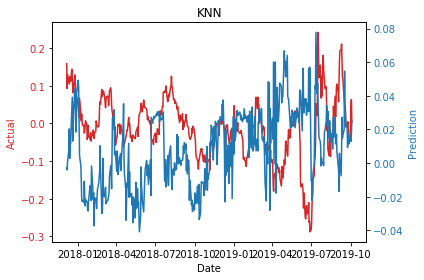

In [163]:

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Actual', color=color)
ax1.plot(date_test, Y_test, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Prediction', color=color)  # we already handled the x-label with ax1
ax2.plot(date_test, pred_KNN, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('KNN')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()